# This notebook aims to add cohort to model and fix some remaining issues:
COHORT DONE!
1. fix model update method (complete) <br>
2. remove hard-coded map config (complete) <br>
3. aerosal transmission

In [2]:
# project directory fix
import os
import sys
sys.path.append('./src')
os.chdir(os.path.dirname(os.path.dirname(sys.path[0])))

In [57]:
from mesa_geo import GeoAgent, AgentCreator, GeoSpace
from mesa.time import BaseScheduler, RandomActivation, SimultaneousActivation
from mesa import datacollection
from mesa import Model
from scipy import stats 
import math
import os
import sys
import warnings


#Shapely Imports
from shapely.geometry import Polygon, Point, LineString
import shapely


#Data Analysis 
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import csv

# Configuration Data and Files
import configparser

#Plot
import matplotlib.pyplot as plt


# Prefix for config data
#os.chdir(os.path.dirname(sys.path[0]))
config_file_path_prefix = './config/'


# parser viz config data
viz_ini_file = 'vizparams.ini'

parser_viz = configparser.ConfigParser()
parser_viz.read(config_file_path_prefix + viz_ini_file)

default_section = parser_viz['DEFAULT_PARAMS']


# parser disease config data

disease_params_ini = 'diseaseparams.ini'
parser_dis = configparser.ConfigParser()
parser_dis.read(config_file_path_prefix + disease_params_ini)
incubation = parser_dis['INCUBATION']


# NPI config data

npi_params_ini = 'NPI.ini'
parser_npi = configparser.ConfigParser()
parser_npi.read(config_file_path_prefix + npi_params_ini)


# school config data


school_params_ini = 'schoolparams.ini'
parser_school = configparser.ConfigParser()
parser_school.read(config_file_path_prefix + school_params_ini)
cohort_config = parser_school['COHORT']





def generate_random(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            return pnt
        
        
        
        
        
        
def find_room_type(room_agents, room_type):
    """
    room_agents: a list containing room agents
    room_type: a valid string of room type: [None, 'restroom_grade_boys', 'lunch_room', 'classroom_grade',
       'restroom_all', 'restroom_grade_girls', 'restroom_KG',
       'classroom_KG', 'community_room', 'library',
       'restroom_special_education', 'restroom_faculty',
       'classroom_special_education', 'health_room', 'faculty_lounge',
       'classroom_preschool', 'restroom_preschool']
    """
    out = []
    for agent in room_agents:
        if agent.room_type == room_type:
            out.append(agent)
    return out










class Human(GeoAgent):
            
    # plot config

    marker = default_section['marker']
    colordict = {"healthy": default_section['healthy'], 'exposed': default_section['exposed'], 'infectious': default_section['infectious']}
    edgedict = {"healthy": default_section['healthy_edge'], 'exposed': default_section['exposed_edge'], 'infectious': default_section['infectious_edge']}
    sizedict = {"healthy": default_section['healthy_size'], 'exposed': default_section['exposed_size'], 'infectious': default_section['infectious_size']}
    

    
    
    # dummy config for data collection
    viral_load = None
    
    
    
    # UPDATE 10/16: move stats to class level
     

    
    
    
    
    # infectious curve config
    ###################################### 
    # based on gamma fit of 10000 R code points

    shape, loc, scale = (float(incubation['shape']), float(incubation['loc']), float(incubation['scale']))

    # infectious curve
    range_data = list(range(int(incubation['lower_bound']), int(incubation['upper_bound']) + 1))
    infective_df = pd.DataFrame(
        {'x': range_data,
         'gamma': list(stats.gamma.pdf(range_data, a=shape, loc=loc, scale=scale))
        }
    )
    #########################################

    
    def __init__(self, unique_id, model, shape, room, health_status = 'healthy'):
        super().__init__(unique_id, model, shape)
        

        
        # disease config

        self.health_status = health_status
        prevalence = float(parser_dis['ASYMPTOMATIC_PREVALENCE']['prevalence'])
        self.asymptomatic = np.random.choice([True, False], p = [prevalence, 1-prevalence])
        self.symptoms = False
        
        # UPDATE 10/17: delay infection by 1 day to avoid infection explosion
        self.infective = False
        
        # symptom onset countdown config
        ##########################################
        # From 10000 lognorm values in R
        countdown = parser_dis['COUNTDOWN']
        shape, loc, scale =  (float(countdown['shape']), float(countdown['loc']), float(countdown['scale']))

        lognormal_dist = stats.lognorm.rvs(shape, loc, scale, size=1)

        num_days = min(np.round(lognormal_dist, 0)[0], int(countdown['upper_bound'])) # failsafe to avoid index overflow
        self.symptom_countdown = int(num_days)
        #######################################
        
        

        
        self.room = room
        self.x = self.shape.x
        self.y = self.shape.y


        
        

 
    def update_shape(self, new_shape):
        self.shape = new_shape
        self.x = self.shape.x
        self.y = self.shape.y
        
    
    def __update(self):
        # UPDATE 10/16: reorganized things from Bailey's update
        # TODO: currently mask has no functionality other than reducing transmission distance, is this faithful?


        # mask wearing reduces droplet transmission max range
        # infection above max range is considered as aerosal transmission
        if self.mask and not (self.model.activity[self.room.schedule_id] == 'lunch'):
            neighbors = self.model.grid.get_neighbors_within_distance(self, int(parser_npi['MASKS']['infection_distance']))
        else:
            neighbors = self.model.grid.get_neighbors_within_distance(self, int(parser_npi['NO_NPI']['infection_distance']))

        

                                               
        if self.health_status == 'exposed' and self.infective:

            # normalize symptom countdown value to infectious distribution value
            # 0 being most infectious
            # either -10 or 8 is proven to be too small of a chance to infect others, thus covering asympotmatic case


            countdown_norm = min(int(incubation['upper_bound']), max(int(incubation['lower_bound']), 0 - self.symptom_countdown))
            temp_prob = self.infective_df[self.infective_df['x'] == countdown_norm]['gamma'].iloc[0]

            
            for neighbor in neighbors:

                # Check class is Human                            
                if issubclass(type(neighbor), Human):
                    if neighbor.unique_id != self.unique_id:                   
                        # TODO: update this to a more realistic scale
                        agent_distance = self.shape.distance(neighbor.shape)

                        try:
                            dist_bias = np.sqrt(min(1, 1/agent_distance))
                        except:
                            dist_bias = 1


                        # row a dice of temp_prob*dist_bias chance to expose other agent
                        infective_prob = np.random.choice ([True, False], p = [temp_prob*dist_bias, 1 - (temp_prob*dist_bias)])

                        if infective_prob and self.__check_same_room(neighbor):
                            neighbor.health_status = 'exposed'

         
        
    def __check_same_room(self, other_agent):
        '''
        check if current agent and other agent is in the same room
        
        the purpose of this function is to make sure to eliminate edge cases that one agent near the wall of its room
        infects another agent in the neighboring room
        
        this is at this iteration of code only implemented for class purpose, as unique id check is way more efficient
        
        later implementation should add attribute to human agent for current room
        
            other_agent: other agent to check
            returns: boolean value for if the two agents are in the same room
        '''
        same_room = True
        if self.model.activity[self.room.schedule_id] == 'class':
            same_room = (self.room.unique_id == other_agent.room.unique_id)
        return same_room
    
    
    def __move(self, move_spread = 12, location = None):
        '''
        Checks the current location and the surrounding environment to generate a feasbile range of destination (the area
        of a circle) for agent to move to.
        The radius of the circle is determined by agent's move_factor.
        Assigns new point to override current point.
        '''   
        
        if not location:
            location = self.room
        move_spread = location.shape.intersection(self.shape.buffer(move_spread))
        minx, miny, maxx, maxy = move_spread.bounds
        while True:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))            
            # check if point lies in true area of polygon
            if move_spread.contains(pnt):
                self.update_shape(pnt)
                break
    
    
    def plot(self):
        plt.plot(
            self.shape.x, self.shape.y, 
            marker=self.marker, 
            mec = self.edgedict[self.health_status],
            color = self.colordict[self.health_status],
            markersize = self.sizedict[self.health_status]
                )
        

                        
        
        
        





class Student(Human):
    def __init__(self, unique_id, model, shape, room, health_status = 'healthy', mask_on=False):
        super().__init__(unique_id, model, shape, room, health_status)

        viz_ini_file = 'vizparams.ini'
        parser = configparser.ConfigParser()
        parser.read(config_file_path_prefix + viz_ini_file)
        student_viz_params = parser['STUDENT']

        self.cohort = None
        self.grade = self.room.room_type.replace('classroom_', '')
        self.mask = mask_on        
        self.seat = Point(self.shape.x, self.shape.y)
        self.marker = student_viz_params['marker']
        
        
        
        
        
        
        self.out_of_place = False        
        self.prev_activity = None
        self.lunch_count = 0
        
        
        
        
        
                

                

                
                
    def step(self):
        self._Human__update()
        
        
        if self.model.schedule_type != "Simultaneous":
            self.advance()
        
    
    
    def advance(self):
        
        activity = self.model.activity[self.room.schedule_id]
        # case 1: student in class
        if activity == 'class': 
            if self.prev_activity != activity:
                self.prev_activity = activity
                self.update_shape(self.seat)
                
            if self.room.prob_move:
                self.out_of_place = True
                self._Human__move()
            else:
                if self.out_of_place:
                    self.update_shape(self.seat)
                    self.out_of_place = False
                    
                
                
        # UPDATE Christmas now students move within cohort range
        # case 2: student in recess            
        elif activity == 'recess':
            ### TODO: recess yard assignment is hard coded ###

                
            if self.prev_activity != activity:
                self.update_shape(generate_random(self.cohort.shape))
                self.prev_activity = activity
            
            self._Human__move(move_spread=15, location = self.cohort)
        
        
        
        # case 3: student having lunch
        elif activity == 'lunch':
            #in class lunch case
            if self.model.inclass_lunch or self.grade != 'grade':
                if self.prev_activity != activity:
                    self.update_shape(self.seat)
                    self.prev_activity = activity
                    self.out_of_place = True
                    self._Human__move()
                else: 
                    if self.out_of_place:
                        self.update_shape(self.seat)
                        self.out_of_place = False

                    
            #in cafeteria lunch case
            else:
                if self.prev_activity != activity:
                    self.update_shape(generate_random(self.model.lunchroom.shape))
                    self.prev_activity = activity

                # enter lunch cafeteria, move free for 2 iteration
                if self.lunch_count < 2:
                    self._Human__move(move_spread=40, location = self.model.lunchroom)

                # finds seat, settle in seat until finish lunch
                elif self.lunch_count == 2:
                    self.update_shape(self.model.lunchroom.seats[0])
                    # remove seat from seat list if the student occupies it
                    self.model.lunchroom.seats = self.model.lunchroom.seats[1:]

                # release seat back to seat list
                elif self.lunch_count == 7:
                    self.model.lunchroom.seats.append(self.shape)
                    self.lunch_count = -1

            
                self.lunch_count += 1
    
                        
                            
                            
                            




                
                
    
class Teacher(Human):
    def __init__(self, unique_id, model, shape, room, health_status = 'healthy',mask_on=True):
        super().__init__(unique_id, model, shape, room, health_status)
        self.mask = mask_on
        self.classroom = self.room # TODO: for future development enabling Teachers to move to other room during non-class time

        viz_ini_file = 'vizparams.ini'
        parser = configparser.ConfigParser()
        parser.read(config_file_path_prefix + viz_ini_file)
        teacher_viz_params = parser['TEACHER']
        
        self.marker = teacher_viz_params['marker']
        self.edgedict = {"healthy": teacher_viz_params['healthy_edge'], 'exposed': teacher_viz_params['exposed_edge'], 'infectious': teacher_viz_params['infectious_edge']}
        self.sizedict = {"healthy": teacher_viz_params['healthy_size'], 'exposed': teacher_viz_params['exposed_size'], 'infectious': teacher_viz_params['infectious_size']}
    
    
    def step(self):
        self._Human__update()
        
        if self.model.schedule_type != "Simultaneous":
            self.advance()
        
        
    def advance(self):
        self._Human__move()
                
        
# UPDATE Christmas add cohort agent
class Cohort(GeoAgent):
    # dummy config for data collection
    health_status = None
    symptoms = None
    x = None
    y = None
    viral_load = None
    max_intersection_prob = eval(cohort_config['max_intersection_prob'])
    
    def __init__(self, unique_id, model, shape, students, recess_yard, radius):
        super().__init__(unique_id, model, shape)
        self.radius = radius
        self.students = students
        self.recess_yard = recess_yard
        for student in self.students:
            student.cohort = self
        
    def step(self):
        # currently does nothing
        if self.model.schedule_type != "Simultaneous":
            self.advance()
    
    def advance(self):
        if self.model.step_count == 0:
            while True:
                self.shape = self.__update_cohort_location()
                if self.__check_intersection():
                    break
                
            
    def __update_cohort_location(self):
        while True:
            center = generate_random(self.recess_yard.shape)
            shape = center.buffer(self.radius)
            if self.recess_yard.shape.contains(shape):
                    return shape
    
    
    def __check_intersection(self):
        other_cohorts = [a for a in list(self.model.grid.get_intersecting_agents(self)) if issubclass(type(a), Cohort)]
        for a in other_cohorts:
            if a.unique_id != self.unique_id:
                if self.shape.intersection(a.shape).area > self.max_intersection_prob * self.shape.area:
                    return False
        return True
            
            
            
    



class Classroom(GeoAgent):
    
    
    # dummy config for data collection
    health_status = None
    symptoms = None
    x = None
    y = None
    
    
    def __init__(self, unique_id, model, shape, room_type):
        super().__init__(unique_id, model, shape)
        #self.occupants = occupants #List of all occupants in a classroom
        #self.barrier = barrier_type
        self.room_type = room_type
        self.viral_load = 0
        self.prob_move = False
        self.schedule_id = None
    
    def step(self):
        # roll weighted probability for current step having in-class activity
        self.prob_move = np.random.choice([True, False], p = [0.2, 0.8])
        
        
        # UPDATE 10/16: move aerosal update entirely to room object, better for future room volume inclusion
        # TODO: this aerosal version is very immature! 
        
        occupants = [a for a in list(self.model.grid.get_intersecting_agents(self)) if issubclass(type(a), Human)]
        # this upates room viral_load to an arbitrary that's scaled with num of covid patients and area of room
        # should change to volume of room later
        self.viral_load += len([a for a in occupants if a.health_status != "healthy"])/self.shape.area
        
        
        if self.model.schedule_type != "Simultaneous":
            self.advance()
        
        
        
    def advance(self):
        # Don't infect any agent at this point
        # intended for aerosal transmission
        '''
        for agent in occupants:
            ### TODO: check literature for aerosal infection ###
            if issubclass(type(agent), Human):
                prob_exposed = self.viral_load/100
                
                if agent.mask:
                    prob_exposed -= 0.1 # particularly here mask effect on room aerosal transmission
                    if prob_exposed < 0: 
                        prob_exposed = 0
                
                if np.random.choice([True, False], p = [prob_exposed, 1-prob_exposed]):
                    agent.health_status = 'exposed'
        '''

                    
        
        # ventilation natrually
        ### TODO: check literature for aerosal infection ###
        self.viral_load = max(self.viral_load-0.002, 0)
        
        if self.schedule_id is not None:
            if "classroom" in self.room_type:
                if self.model.activity[self.schedule_id] != 'class':
                    self.ventilate()
        elif (self.room_type == 'lunch_room') and (not ('lunch' in self.model.activity.to_numpy())):
            self.ventilate()
            
        
    def ventilate(self):
        ### TODO: check literature for aerosal infection ###
        self.viral_load = max(self.viral_load-0.05, 0)
        

                
    def generate_seats_lunch(self, xwidth, ywidth):
        
        self.seats = []
        xmin, ymin, xmax, ymax = self.shape.bounds
        xcoords = xmin + xwidth
        ycoords = ymin + ywidth
        
        y_pointer = ycoords
        x_pointer = xcoords
        
        while (xcoords < xmax):
            
            while (ycoords < ymax):
                self.seats.append(Point(xcoords, ycoords))
                ycoords += ywidth
                
            xcoords += xwidth
            ycoords = y_pointer
            
        np.random.shuffle(self.seats)
        
        
        
        
###########################################################

    def generate_seats(self, N, width, style='individual'):

        self.seats = []
        shape = self.shape

        if style == 'individual':         
            center = shape.centroid
            md = math.ceil(N**(1/2))
            pnt = Point(center.x - width*md//2, center.y - width*md//2)
            for i in range(md):
                for j in range(md+1):
                    self.seats.append(Point(pnt.x + i*width, pnt.y + j*width))

        elif style == 'circular':
            dataframe_seats_desks = self.generate_seats_circular(shape, self.generate_desks(shape), N)
            self.seats = dataframe_seats_desks.seat.tolist()
            self.desks = dict(dataframe_seats_desks[['desk_id', 'desk']].drop_duplicates(['desk_id']).set_index('desk_id')['desk'])

            
        
        
    def generate_desks(self, shape, radius_desk=12, spacing_desk=20):

        desks = []
        minx, miny, maxx, maxy = shape.bounds

        x_start, y_start = minx + radius_desk, maxy - radius_desk
        x_start += 0.2
        y_start -= 0.2
        desk = Point(x_start, y_start).buffer(radius_desk)
        net_space = radius_desk + spacing_desk

        x_coordinate = x_start
        y_coordinate = y_start

        while True:
            desks.append(desk)        

            x_coordinate += net_space

            if (y_coordinate < miny) and (x_coordinate > maxx):         
                break

            if x_coordinate > maxx:
                x_coordinate -= net_space
                x_coordinate = x_start 
                y_coordinate = y_coordinate - net_space


            desk = Point(x_coordinate, y_coordinate).buffer(radius_desk)    

        desks = gpd.GeoSeries(desks)
        desks  = desks[desks.apply(lambda desk: shape.intersects(desk))]

        return desks


    def generate_seats_circular(self, shape, desks, N, num_children_per_desk=5):

        def return_coords(desk, num_children_per_desk):
            boundary = list(desk.boundary.coords)
            step = len(boundary) // num_children_per_desk
            boundary = pd.Series(boundary[::step])
            boundary = boundary[:num_children_per_desk]
            return boundary.apply(Point).values.tolist() 


        result = desks.apply(return_coords, args=(num_children_per_desk,))
        dataframe = pd.DataFrame((desks, result)).T
        dataframe = dataframe.rename({0:'desk', 1:'seats'}, axis=1)

        desk_series = dataframe.apply(lambda row: [row['desk'] for i in range(len(row['seats']))], axis=1)

        desk_series = desk_series.sum()
        result = result.sum()

        final_df = pd.DataFrame()
        final_df['desk'] = desk_series
        final_df['seat'] = result

        final_df['desk_id'] = final_df['desk'].apply(str)

        to_drop = final_df[(gpd.GeoSeries(final_df['seat']).distance(shape) >= 0.1) & (~final_df['seat'].apply(lambda seat: shape.contains(seat)))].drop_duplicates(subset=['desk_id'])
        to_drop = to_drop.desk_id.values


        return final_df[~final_df.desk_id.isin(to_drop)][:N]



            
##############################################################
        
        
    


class School(Model):

    
    
    schedule_types = {"Sequential": BaseScheduler,
                      "Random": RandomActivation,
                      "Simultaneous": SimultaneousActivation}
    
    
    
    


    
    def __init__(self, map_path, schedule_path, grade_N, KG_N, preschool_N, special_education_N, 
                 faculty_N, seat_dist, init_patient=3, attend_rate=1, mask_prob=0.516, 
                 inclass_lunch=False, schedule_type="Simultaneous"):
        # zipcode etc, for access of more realistic population from KG perhaps
        
        
        
        # model param init
        self.__mask_prob = mask_prob
        self.inclass_lunch = inclass_lunch
        self.seat_dist = math.ceil(seat_dist/(attend_rate**(1/2)))
        self.idle_teachers = [] # teachers to be assigned without a classroom
        self.init_patient = init_patient

        
        


        # mesa model init
        self.running = True
        self.grid = GeoSpace()
        self.schedule_type = schedule_type
        self.schedule = self.schedule_types[self.schedule_type](self)
        
        
        
        #data collect init
        model_reporters = {"day": "day_count",
                           "cov_positive": "infected_count"}
        agent_reporters = {"unique_id": "unique_id",
                           "health_status": "health_status",
                           "symptoms": "symptoms",
                           "x": "x",
                           "y": "y",
                           "viral_load": "viral_load"}
        self.datacollector = datacollection.DataCollector(model_reporters=model_reporters, agent_reporters=agent_reporters)
        
        

        
        
        
        school_gdf = gpd.read_file(map_path)



        
        
        # room agent init
        self.room_agents = school_gdf.apply(lambda x: Classroom(
        unique_id = x["Id"], 
        model = self,
        shape = x["geometry"], 
        room_type = x["room_type"]),
                     axis=1
                    ).tolist()

        self.grid.add_agents(self.room_agents)
        
        
        
        # stats tracking init
        self.infected_count = 0
        self.step_count = 0
        self.day_count = 0
        self.num_exposed = 0
        
        
        
        # student activity init
        self.schoolday_schedule = pd.read_csv(schedule_path)
        self.activity = None
        
        
        # id tracking init
        self.__teacher_id = 0
        self.__student_id = 0
        self.__cohort_id = 0
        self.__faculty_N = faculty_N
        self.schedule_ids = self.schoolday_schedule.columns
        
        
        
        # geo-object tracking init
        self.recess_yards = find_room_type(self.room_agents, 'recess_yard')
        self.cohorts = []
        
        
        # UPDATE Christmas cohort generation
        def generate_cohorts(students, N):
            '''
            generate cohorts with within/out-of classroom probability, cohort size probablity
            example: students have 80% chance to have a friend in same room, 20% chance to have a friend in different room
            and 50% to have a cohort size of 5, 20% size 2, 15% size 4, 10% size 3, 5% size 1
            
            students: a 2d list containing list of students in each room
                students[k] is a list of student agents (in same classroom room)
                
            '''

            size_prob = eval(cohort_config['size_prob'])
            same_room_prob = eval(cohort_config['same_room_prob'])
            
            
            
            radius = eval(cohort_config['radius'])
            
            
            
            size_val_list = list(size_prob.keys())
            size_prob_list = list(size_prob.values())
            same_room_val_list = list(same_room_prob.keys())
            same_room_prob_list = list(same_room_prob.values())
            
            
            # start at room 0
            cur_room = 0

            while N > 0:

                cur_size = np.random.choice(size_val_list, p = size_prob_list)
                if N <= max(size_val_list):
                    cur_size = N

                # get same-room cohort size 
                cur_same = sum(np.random.choice(same_room_val_list, size = cur_size, p = same_room_prob_list))

                # add students from current room to current cohort
                cur_same = min(cur_same, len(students[cur_room]))          
                cohort = students[cur_room][:cur_same]
                students[cur_room] = students[cur_room][cur_same:]


                room_idx = list(range(len(students)))

                other_room = room_idx[:]
                other_room.remove(cur_room)

                # add students from other rooms to cohort
                if not len(other_room):
                    rand_room = [cur_room]*(cur_size - cur_same)
                else:
                    rand_room = np.random.choice(other_room ,size = (cur_size - cur_same))
                    
                for r in rand_room:
                    # update and remove r if r is an empty room
                    while True:
                        try:
                            cohort.append(students[r][0])
                            students[r] =students[r][1:]
                            break
                        except:
                            if r in other_room:
                                other_room.remove(r)
                            if not len(other_room):
                                r = cur_room
                            else:
                                r = np.random.choice(other_room)


                            
                            
                            
                # TODO: recess yard is current hard coded             
                recess_yard = self.recess_yards[0]
                if cohort[0].grade != 'grade':
                    recess_yard = self.recess_yards[1]
                    
                    
                # make cohort agent with dummy shape
                cur_cohort = Cohort("Cohort" + str(self.__cohort_id), self, Point(0,0), cohort, recess_yard, cur_size*radius)
                self.grid.add_agents(cur_cohort)
                self.schedule.add(cur_cohort)
                self.cohorts.append(cur_cohort)
                self.__cohort_id += 1
                
                
                # remove empty rooms
                students = [room for room in students if len(room) > 0]

                # rolling update to minimize student pop edge cases 
                # fail safe break
                if not len(students):
                    break
                cur_room = (cur_room + 1)%len(students)

                # update student population
                N -= cur_size
            
            
            
        
        def init_agents(room_type, N, partition=False):
            '''
            batch initialize human agents into input room type rooms with equal partition size
            
            room_type: a valid string of room type: [None, 'restroom_grade_boys', 'lunch_room', 'classroom_grade',
               'restroom_all', 'restroom_grade_girls', 'restroom_KG',
               'classroom_KG', 'community_room', 'library',
               'restroom_special_education', 'restroom_faculty',
               'classroom_special_education', 'health_room', 'faculty_lounge',
               'classroom_preschool', 'restroom_preschool']
            '''

                
            rooms = find_room_type(self.room_agents, room_type)
            
            
            # if student group should be seperated to different day schedules
            # assigning schedule_id to equally partitioned rooms
            # currently only grade 1-5 "grade" students need to be partitioned, 
            partition_size = len(rooms)
            if partition:
                partition_size = math.ceil(partition_size/len(self.schedule_ids))
                
            class_size = N//len(rooms)
            remaining_size = N%len(rooms)
            
            #track all students of same grade type
            all_students = []
            for i, classroom in zip(range(len(rooms)), rooms):
                
                
                
                # spread remaining student into all classrooms
                c_size = class_size
                if remaining_size > 0:
                    remaining_size -= 1
                    c_size += 1
                
                
                classroom.generate_seats(c_size, self.seat_dist)# , style='circular')
                # TODO: circular desk is buggy, not generating enough table for small rooms (shape out of bound)

                classroom.schedule_id = self.schedule_ids[i//partition_size]
                
                
                #track students within the same room
                students = []
                
                for idx in range(c_size):   
                    try:
                        
                        pnt = classroom.seats[idx]
                    except:
                        print("error idx: ", idx)
                        print("c_size: ", c_size)
                        print("len of seats", len(classroom.seats))
                        raise Exception('idx')
                     
                    mask_on = np.random.choice([True, False], p=[mask_prob, 1-mask_prob])
                    agent_point = Student(model=self, shape=pnt, unique_id="S"+str(self.__student_id), room=classroom, mask_on=mask_on)
                    
                    self.grid.add_agents(agent_point)
                    self.schedule.add(agent_point)
                    self.__student_id += 1
                    
                    # add student to room temp list
                    students.append(agent_point)

                    
                
                #add teacher to class
                pnt = generate_random(classroom.shape)
                agent_point = Teacher(model=self, shape=pnt, unique_id="T"+str(self.__teacher_id), room=classroom)
                self.grid.add_agents(agent_point)
                self.schedule.add(agent_point)
                self.idle_teachers.append(agent_point)
                self.__teacher_id += 1
                self.__faculty_N -= 1
                
                # add room students list to all students 
                # shuffle students for efficiency improvement
                np.random.shuffle(students)
                all_students.append(students)
            
            
            
            
            #UPDATE Christmas
            #generate cohort with temp student list
            generate_cohorts(all_students, N)
            
            


        
        # initialize all students and teachers in classrooms
        init_agents("classroom_grade", int(grade_N*attend_rate), partition=True)        
        # keep track of student types
        #self.grade_students = [a for a in list(self.schedule.agents) if isinstance(a, Student)]        
        init_agents("classroom_KG", int(KG_N*attend_rate))
        init_agents("classroom_preschool", int(preschool_N*attend_rate))        
        #self.pkg_students = [a for a in list(set(self.schedule.agents).difference(self.grade_students)) if isinstance(a, Student)]
        init_agents("classroom_special_education", int(special_education_N*attend_rate))
  
            

        # dump remaining teacher to faculty lounge
        for f_lounge in find_room_type(self.room_agents, "faculty_lounge"):
            f_lounge.schedule_id = self.schedule_ids[0]
            
            for i in range(self.__faculty_N):

                pnt = generate_random(f_lounge.shape)
                agent_point = Teacher(model=self, shape=pnt, unique_id="T" + str(self.__teacher_id), room=f_lounge)
                self.grid.add_agents(agent_point)
                self.schedule.add(agent_point)
                self.__teacher_id += 1
        
        #self.people = list(self.schedule.agents)
        
        # add rooms to scheduler at last 
        for room in self.room_agents:
            self.schedule.add(room)
            
            
            
            
        self.lunchroom = find_room_type(self.room_agents, 'lunch_room')[0]
        self.lunchroom.generate_seats_lunch(3, 12)
            
            
            
     
    
    
    def small_step(self):
        self.schedule.step()
        self.grid._recreate_rtree() 
        
        
        
    def add_N_patient(self, N): 
        patients = random.sample([a for a in self.schedule.agents if isinstance(a, Student)], N)
        for p in patients:
            p.health_status = "exposed"
            p.asymptomatic = True
            p.infective = True
    
    
    def show(self):
        '''
        plot current step visualization
        deprecated since end of model visualization update
        '''
        
        # UPDATE 10/16: add deprecation warning
        message  = "this function is no longer used for performance issues, check output_image.py for end of model visualization"
        warnings.warn(message, DeprecationWarning)


        school_geometry = gpd.GeoSeries([a.shape for a in self.room_agents])
        school_map = gpd.GeoDataFrame({"viral_load" : [min(a.viral_load, 5) for a in self.room_agents]})
        school_map.geometry = school_geometry
        basemap = school_map.plot(column = "viral_load", cmap="Reds", alpha = 0.5, vmin = 0, vmax = 5)
        school_map.boundary.plot(ax = basemap, color='k', linewidth=0.2)

        list(map(lambda a: a.plot(), [a for a in self.schedule.agents if issubclass(type(a), Human)]))
        
        hour = 9 + self.step_count*5//60 # assume plot start at 9am
        minute = self.step_count*5%60
        plt.title("Iteration: Day {}, ".format(self.day_count + 1) + "%d:%02d" % (hour, minute), fontsize=30)

        
    
    def __update_day(self):
        '''
        update incubation time, reset viral_load, remove symptomatic agents, etc for end of day
        '''

        
        for a in self.schedule.agents[:]:
            if issubclass(type(a), Human):

                    
                if a.symptoms:
                    # remove agent if symptom onset
                    if isinstance(a, Teacher):
                        # assign a new teacher to position
                        new_teacher = self.idle_teachers.pop()
                        new_teacher.shape = a.shape
                        new_teacher.room = a.room
                        new_teacher.classroom = a.classroom
                    self.schedule.remove(a)
                    self.grid.remove_agent(a)
                    
                # UPDATE 10/16: infectious made obsolete, end of day update rework
                elif a.health_status == "exposed":
                    # UPDATE 10/17: update infective delay if agent is not infective by end of day
                    a.infective = True
                    a.symptom_countdown -= 1
                    # calculate when symptoms begin to show using 0-15 density
                    if a.symptom_countdown <= 0:
                        if a.symptom_countdown == 0: 
                            self.infected_count += 1
                        # update model stat for total infected
                        # negative countdown means this agent is asymptomatic
                        
                        if not a.asymptomatic:
                            # this is a really small chance, however possible
                            # set symtoms to true
                            # next day this agent will be removed from the model
                            a.symptoms = True

            else:
                # reset viral_load of room agents
                a.viral_load = 0
        
    def step(self):
        '''
        simulate a day with school day schedule
        '''
        if not self.schedule.steps:
            self.add_N_patient(self.init_patient)
        
        
        
        for i, row in self.schoolday_schedule.iterrows():
            self.activity = row
            self.datacollector.collect(self)
            self.schedule.step()
            self.grid._recreate_rtree() 
            self.step_count += 1
            
            
        self.__update_day()  
        self.grid._recreate_rtree() 
        self.day_count += 1        
        self.step_count = 0


In [58]:
plt.rcParams["figure.figsize"] = (15,15)

In [59]:
map_path = "./layouts/schoollayout1/schoollayout1_processed.shp"
schedule_path = "./schedule_data/day_schedule.csv" #small schedule has only 5 steps per day for testing purposes
#full day schedule should be "day_schedule.csv" 
schedule_steps = 90 # full day_schedule steps should be 90


# if you wish to use google sheet parameter input, you'll have to follow instructions for getting credentials of the sheet api
# follow the first two steps in:
# https://developers.google.com/sheets/api/quickstart/python
# and save your credentials in the src folder as listed below
SHEET_URL = 'https://docs.google.com/spreadsheets/d/1Quyyey5B_kdQK1_OU0OkIDGZE27tuUfjZ6hCsV99-sM'
credentials = './src/credentials.json'


# two types of parameter setups available for batchrunner
# pre-setup for fixed/variable parameter dictionaries (consistant with mesa batchrunner)
######################
grade_N = 350
KG_N = 50
preschool_N = 50
special_education_N = 10
faculty_N = 40
seat_dist = 12
mask_prob = 0.516
days = 15
max_steps = days*schedule_steps
iterations = 1
####################

In [46]:
x = school.schedule.agents[-1]

In [68]:
x.generate_seats(22,1,style="circular")

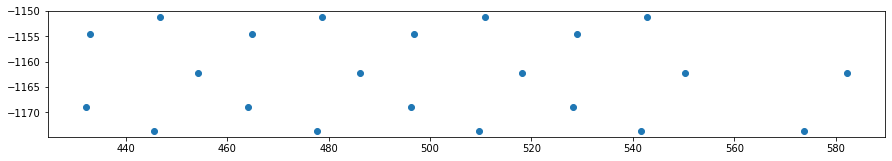

In [73]:

gpd.GeoSeries(x.seats).plot()

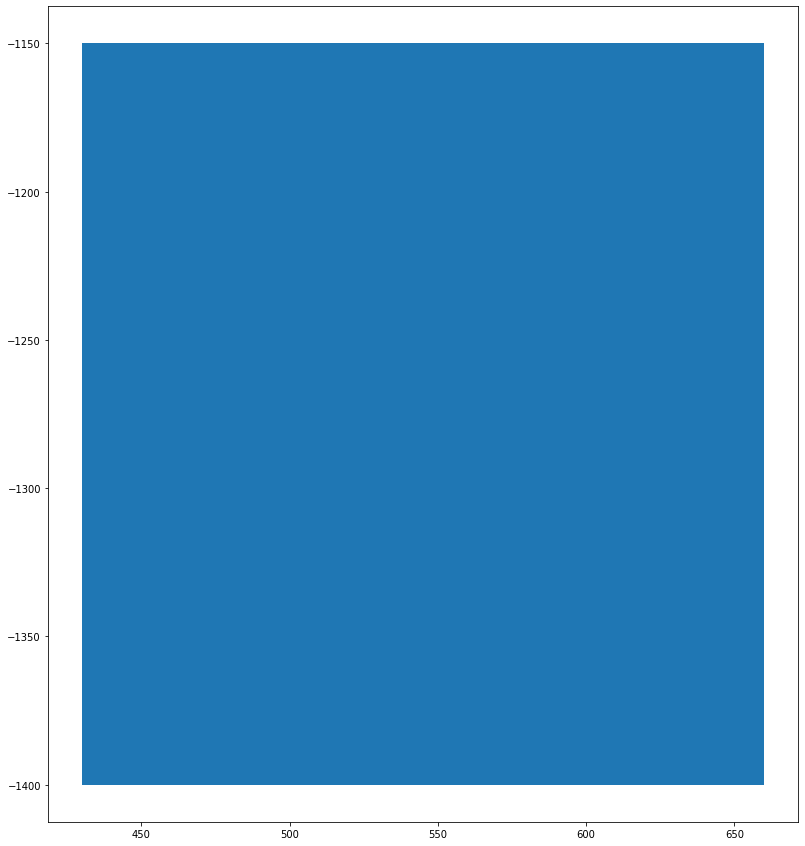

In [75]:
gpd.GeoSeries(x.shape).plot()

In [60]:
school = School(map_path, schedule_path, grade_N, KG_N, preschool_N, special_education_N, 
                 faculty_N, seat_dist, init_patient=3, attend_rate=1, mask_prob=0.5, inclass_lunch=False)

error idx:  20
c_size:  22
len of seats 20


Exception: idx

In [6]:
%%time
school.step()

Wall time: 1min 9s


In [7]:
import output_image

In [8]:
agent_df = school.datacollector.get_agent_vars_dataframe()
model_df = school.datacollector.get_model_vars_dataframe()

In [9]:
output_image.write_output("{'temp': True}", [model_df, agent_df], map_path)

C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame 

C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame 

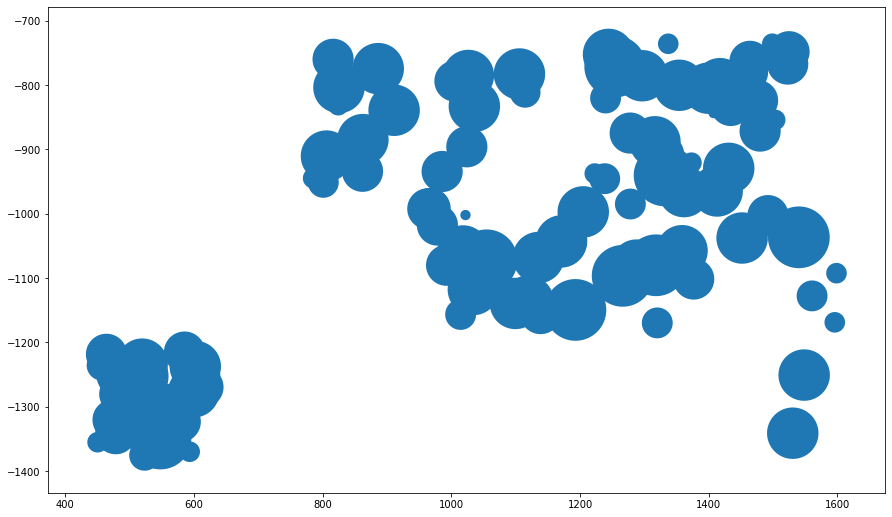

In [11]:
gpd.GeoSeries([a.shape for a in school.cohorts]).plot()